# Vertical Sesimic Profiling inversion

@Author: Ettore Biondi - ebiondi@caltech.edu

We are going to focus our attention to a common approach when dealing with geophysical inverse problems, regularization and prior information. In this example we will invert synthetic data from a vertical seismic profiling survey. To do so, we will discretize the following equation:
\begin{align}
t(z) =  \int_{0}^{z} \frac{1}{v(z')}dz',
\end{align}
where $t(z)$ is the traveltime from the surface to the depth $z$ and $v(z')$ represents the propagation speed of the medium. To make the problem linear we will parameterize the problem using slowness instead of speed. The discrete version for a regular $z$ sampling of it can be written as follows:
\begin{align}
t_i =  \sum_{j=0}^{N_i} s_j \Delta z,
\end{align}
where $\Delta z$ represents the sampling interval in the $z$ direction, while $t_i$ and $s_j$ are the traveltime and slowness at $z_i=N_i \Delta z$ depth, respectively.
In this example we will assume that the true subsurface vertical speed is given by the following equation:
\begin{align}
v(z)=3000 + \sqrt{1000 z},
\end{align}
expressed in km/s.

In [1]:
import numpy as np
import occamypy as o

o.backend.set_seed_everywhere(42)

# Plotting
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
rcParams.update({
    'image.cmap'     : 'gray',
    'image.aspect'   : 'auto',
    'image.interpolation': None,
    'axes.grid'      : True,
    'figure.figsize' : (6, 4),
    'savefig.dpi'    : 300,
    'axes.labelsize' : 14,
    'axes.titlesize' : 16,
    'font.size'      : 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex'    : True,
    'font.family'    : 'serif',
    'font.serif'     : 'Latin Modern Roman',
})


WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


/nas/home/fpicetti/miniconda3/envs/occd/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
# Definition of the modeling operator forward and its adjoint
class VSP(o.Operator):
    """
    Vertical Sesimic Profiling operator
    """
    
    def __init__(self, model, data, dz: float, desampling: int):
        """
        VSP constructor
        
        Args:
            model: domain vector
            data: range vector
            dz: sampling step for depth
            desampling: desampling of data points
        """
        super(VSP, self).__init__(domain=model, range=data)
        self.name = "VSP"
        self.dz = dz
        self.desampling = int(desampling)
        self.M = model.shape[0]
        self.N = data.shape[0]
        
        if(self.M-2) < (self.N-2)*self.desampling:
            raise ValueError("ERROR! Too many data points! Change desampling or number of data points")
        return
    
    def forward(self, add, model, data):
        """slowness -> traveltime"""
        self.checkDomainRange(model, data)
        if not add:
            data.zero()
        
        data[0] += model[0]*dz
        
        for idata in range(1,self.N-1):
            data[idata] += np.sum(model[:(idata)*self.desampling+1])*dz
        
        data[-1] += np.sum(model[:])*dz
        return
    
    def adjoint(self, add, model, data):
        """traveltime -> slowness"""
        self.checkDomainRange(model,data)
        if not add:
            model.zero()
        
        model[0] += data[0]*dz
        
        for idata in range(1,self.N-1):
            model[:(idata)*self.desampling+1] += data[idata]*dz

        model[:] += data[-1]*dz
        return

In [3]:
dz = 2.
zmax = 1000.0
z = np.linspace(0.0,zmax,int(zmax/dz)+1)
vel = 3000.0 + np.sqrt(1000.0*z)
slowness = 1.0/vel
model_true = o.VectorNumpy(slowness)

# Desampling of receivers
desampling = 10 #20 m sampling
ndata = int(zmax/(dz*desampling))+1
data_true = o.VectorNumpy((ndata,))

VSP_10 = VSP(model_true, data_true, dz, desampling)

In [4]:
# Generating observed data
VSP_10.forward(False,model_true,data_true)

In [5]:
VSP_10.dotTest(True)

Dot-product tests of forward and adjoint operators
--------------------------------------------------
Applying forward operator add=False
 Runs in: 0.0005710124969482422 seconds
Applying adjoint operator add=False
 Runs in: 0.0003707408905029297 seconds
Dot products add=False: domain=8.561224e+01 range=8.561224e+01 
Absolute error: 8.526513e-14
Relative error: 9.959456e-16 

Applying forward operator add=True
 Runs in: 0.0005559921264648438 seconds
Applying adjoint operator add=True
 Runs in: 0.0003418922424316406 seconds
Dot products add=True: domain=1.712245e+02 range=1.712245e+02 
Absolute error: 2.842171e-14
Relative error: 1.659909e-16 

-------------------------------------------------


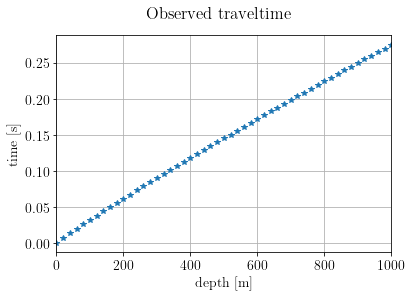

In [6]:
fig, ax = plt.subplots()
ax.plot(z[::desampling], data_true.plot(),'*')
ax.set_xlabel("depth [m]")
ax.set_ylabel("time [s]")
ax.set_xlim(0,1000)
fig.suptitle("Observed traveltime")
plt.show()

In [7]:
# Create LCG solver
LCGsolver = o.CG(o.BasicStopper(niter=2000))
LCGsolver.setDefaults(save_obj=True)

In [8]:
VSP_prob = o.LeastSquares(model_true.clone().zero(), data_true, VSP_10)

In [9]:
LCGsolver.run(VSP_prob,verbose=True)

##########################################################################################
            CG Solver
    Restart folder: /tmp/restart_2022-04-22T01-51-41.263912/
##########################################################################################

iter = 0000, obj = 6.82008e-01, rnorm = 1.17e+00, gnorm = 2.37e+02, feval = 00002
iter = 0001, obj = 5.39592e-03, rnorm = 1.04e-01, gnorm = 6.45e+00, feval = 00004
iter = 0002, obj = 6.22682e-04, rnorm = 3.53e-02, gnorm = 1.27e+00, feval = 00006
iter = 0003, obj = 1.08804e-04, rnorm = 1.48e-02, gnorm = 3.33e-01, feval = 00008
iter = 0004, obj = 2.81691e-05, rnorm = 7.51e-03, gnorm = 1.27e-01, feval = 00010
iter = 0005, obj = 9.57360e-06, rnorm = 4.38e-03, gnorm = 5.82e-02, feval = 00012
iter = 0006, obj = 3.47089e-06, rnorm = 2.63e-03, gnorm = 2.81e-02, feval = 00014
iter = 0007, obj = 1.36467e-06, rnorm = 1.65e-03, gnorm = 1.54e-02, feval = 00016
iter = 0008, obj = 5.69594e-07, rnorm = 1.07e-03, gnorm = 8.86e-03, feval = 00

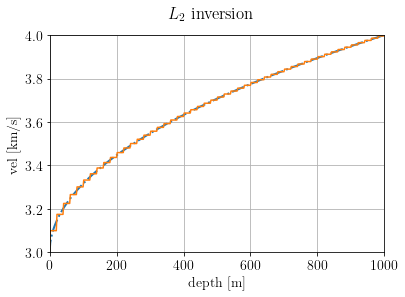

In [10]:
fig, ax = plt.subplots()
ax.plot(z, 1.e-3*vel,label='true model',linewidth=2,linestyle='-.')
ax.plot(z, 1.e-3/VSP_prob.model.plot(),label='inverted model')
ax.set_xlabel("depth [m]"), ax.set_ylabel("vel [km/s]")
ax.set_ylim(3,4), ax.set_xlim(0,1000)
fig.suptitle("$L_2$ inversion")
plt.show()

By looking at the objective function value, we clearly see that we can perfectly match the observed traveltime values. In fact, the problem is underdetermined (i.e., we have more model parameters than observations). Because of this fact, we can only retrieve the average velocity between observation depths. Moreover, we will encounter issues when random noise is present in the recorded data.

In [11]:
noise = data_true.clone().randn(std=1e-3)
noisy_data = data_true.clone().scaleAdd(noise)

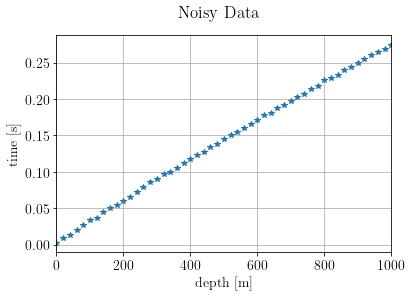

In [12]:
fig, ax = plt.subplots()
ax.plot(z[::desampling], noisy_data.plot(),'*')
ax.set_xlabel("depth [m]")
ax.set_ylabel("time [s]")
ax.set_xlim(0,1000)
fig.suptitle("Noisy Data")
plt.show()

In [13]:
VSP_prob_noise = o.LeastSquares(model_true.clone().zero(), noisy_data, VSP_10)
LCGsolver.run(VSP_prob_noise,verbose=True)

##########################################################################################
            CG Solver
    Restart folder: /tmp/restart_2022-04-22T01-51-41.263912/
##########################################################################################

iter = 0000, obj = 6.80620e-01, rnorm = 1.17e+00, gnorm = 2.37e+02, feval = 00002
iter = 0001, obj = 5.49852e-03, rnorm = 1.05e-01, gnorm = 6.50e+00, feval = 00004
iter = 0002, obj = 6.48304e-04, rnorm = 3.60e-02, gnorm = 1.28e+00, feval = 00006
iter = 0003, obj = 1.26607e-04, rnorm = 1.59e-02, gnorm = 3.31e-01, feval = 00008
iter = 0004, obj = 4.59044e-05, rnorm = 9.58e-03, gnorm = 1.29e-01, feval = 00010
iter = 0005, obj = 2.61762e-05, rnorm = 7.24e-03, gnorm = 6.59e-02, feval = 00012
iter = 0006, obj = 1.71345e-05, rnorm = 5.85e-03, gnorm = 4.07e-02, feval = 00014
iter = 0007, obj = 1.15094e-05, rnorm = 4.80e-03, gnorm = 3.06e-02, feval = 00016
iter = 0008, obj = 7.28932e-06, rnorm = 3.82e-03, gnorm = 2.62e-02, feval = 00

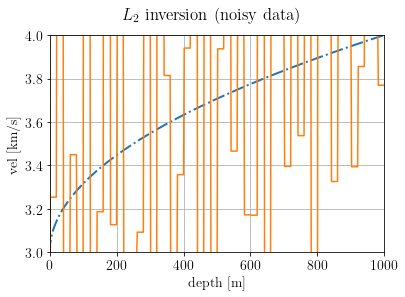

In [14]:
fig, ax = plt.subplots()
ax.plot(z, 1.e-3*vel,label='true model',linewidth=2,linestyle='-.')
ax.plot(z, 1.e-3/VSP_prob_noise.model.plot(),label='inverted model')
ax.set_xlabel("depth [m]"), ax.set_ylabel("vel [km/s]")
ax.set_ylim(3,4), ax.set_xlim(0,1000)
fig.suptitle("$L_2$ inversion (noisy data)")
plt.show()

A simple method to avoid these issues is to add prior knowledge to the inversion. In fact, we can change to problem to be solved and add a regularization term. We will test two kind of regularization: one in which a smooth constraint is added and another one where a prior model is assumed and employed in the regularization term.

In the first case, the objective function to be minimized is the following:
\begin{align}
\phi_{smooth}(\mathbf{m})=\frac{1}{2}\|G \mathbf{m} - \mathbf{d}_{obs} \|_2^2 + \frac{\epsilon^2}{2} \|D_1 \mathbf{m}\|_2^2,
\end{align}
where $\mathbf{m}$ represents the slowness model, $\mathbf{d}_{obs}$ is the observed traveltimes, while $G$ and $D_1$ are the modeling and a first-order derivative operators, respectively. The variable $\epsilon$ is the trade-off weight and is going to be set on the basis of trial and error.

In [15]:
# Instantiating regularization operator
D1 = o.FirstDerivative(model_true, dz, stencil='forward')

# Instantiating regularized problem with noise-free data
VSP_prob_regD1 = o.LeastSquaresRegularized(model_true.clone().zero(),data_true,VSP_10,epsilon=1.0,reg_op=D1)

# Estimating a value for the regularization weight epsilon
epsilon_balance = VSP_prob_regD1.estimate_epsilon(True)
VSP_prob_regD1.epsilon = epsilon_balance * 1e-4

Epsilon Scale evaluation
	Epsilon balancing the data-space gradients is: 4.25e+04


In [16]:
LCGsolver.run(VSP_prob_regD1, verbose=True)

##########################################################################################
            CG Solver
    Restart folder: /tmp/restart_2022-04-22T01-51-41.263912/
##########################################################################################

iter = 0000, obj = 6.82008e-01, rnorm = 1.17e+00, gnorm = 2.37e+02, feval = 00002
iter = 0001, obj = 5.39593e-03, rnorm = 1.04e-01, gnorm = 6.45e+00, feval = 00004
iter = 0002, obj = 6.22693e-04, rnorm = 3.53e-02, gnorm = 1.27e+00, feval = 00006
iter = 0003, obj = 1.08819e-04, rnorm = 1.48e-02, gnorm = 3.33e-01, feval = 00008
iter = 0004, obj = 2.81852e-05, rnorm = 7.51e-03, gnorm = 1.27e-01, feval = 00010
iter = 0005, obj = 9.58737e-06, rnorm = 4.38e-03, gnorm = 5.82e-02, feval = 00012
iter = 0006, obj = 3.47967e-06, rnorm = 2.64e-03, gnorm = 2.82e-02, feval = 00014
iter = 0007, obj = 1.36739e-06, rnorm = 1.65e-03, gnorm = 1.54e-02, feval = 00016
iter = 0008, obj = 5.67808e-07, rnorm = 1.07e-03, gnorm = 8.86e-03, feval = 00

iter = 0183, obj = 8.41318e-11, rnorm = 1.30e-05, gnorm = 3.15e-11, feval = 00368
iter = 0184, obj = 8.41318e-11, rnorm = 1.30e-05, gnorm = 5.85e-11, feval = 00370
iter = 0185, obj = 8.41318e-11, rnorm = 1.30e-05, gnorm = 9.09e-12, feval = 00372
iter = 0186, obj = 8.41318e-11, rnorm = 1.30e-05, gnorm = 1.00e-11, feval = 00374
iter = 0187, obj = 8.41318e-11, rnorm = 1.30e-05, gnorm = 9.54e-12, feval = 00376
iter = 0188, obj = 8.41318e-11, rnorm = 1.30e-05, gnorm = 4.98e-12, feval = 00378
iter = 0189, obj = 8.41318e-11, rnorm = 1.30e-05, gnorm = 1.35e-11, feval = 00380
iter = 0190, obj = 8.41318e-11, rnorm = 1.30e-05, gnorm = 2.18e-11, feval = 00382
iter = 0191, obj = 8.41318e-11, rnorm = 1.30e-05, gnorm = 1.19e-11, feval = 00384
iter = 0192, obj = 8.41318e-11, rnorm = 1.30e-05, gnorm = 4.29e-12, feval = 00386
iter = 0193, obj = 8.41318e-11, rnorm = 1.30e-05, gnorm = 1.23e-11, feval = 00388
iter = 0194, obj = 8.41318e-11, rnorm = 1.30e-05, gnorm = 2.41e-12, feval = 00390
iter = 0195, obj

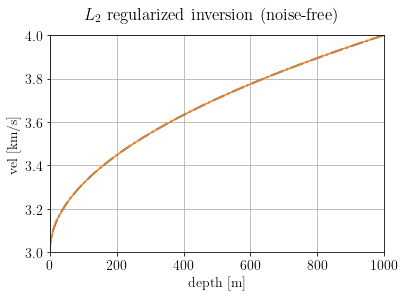

In [17]:
fig, ax = plt.subplots()
ax.plot(z, 1.e-3*vel,label='true model',linewidth=2,linestyle='-.')
ax.plot(z, 1.e-3/VSP_prob_regD1.model.plot(),label='inverted model')
ax.set_xlabel("depth [m]"), ax.set_ylabel("vel [km/s]")
ax.set_ylim(3,4), ax.set_xlim(0,1000)
fig.suptitle("$L_2$ regularized inversion (noise-free)")
plt.show()

In [18]:
# Instantiating regularized problem with noisy data
VSP_prob_regD1 = o.LeastSquaresRegularized(model_true.clone().zero(), noisy_data,VSP_10,epsilon=1.0,reg_op=D1)

# Estimating a value for the regularization weight epsilon
epsilon_balance = VSP_prob_regD1.estimate_epsilon(True)
VSP_prob_regD1.epsilon = epsilon_balance * 5e-2

Epsilon Scale evaluation
	Epsilon balancing the data-space gradients is: 4.25e+04


In [19]:
LCGsolver.run(VSP_prob_regD1, verbose=True)

##########################################################################################
            CG Solver
    Restart folder: /tmp/restart_2022-04-22T01-51-41.263912/
##########################################################################################

iter = 0000, obj = 6.80620e-01, rnorm = 1.17e+00, gnorm = 2.37e+02, feval = 00002
iter = 0001, obj = 7.18211e-03, rnorm = 1.20e-01, gnorm = 8.73e+01, feval = 00004
iter = 0002, obj = 6.04819e-03, rnorm = 1.10e-01, gnorm = 3.00e+01, feval = 00006
iter = 0003, obj = 5.79790e-03, rnorm = 1.08e-01, gnorm = 1.96e+01, feval = 00008
iter = 0004, obj = 5.66089e-03, rnorm = 1.06e-01, gnorm = 1.64e+01, feval = 00010
iter = 0005, obj = 5.54713e-03, rnorm = 1.05e-01, gnorm = 1.61e+01, feval = 00012
iter = 0006, obj = 5.47938e-03, rnorm = 1.05e-01, gnorm = 8.97e+00, feval = 00014
iter = 0007, obj = 4.84232e-03, rnorm = 9.84e-02, gnorm = 4.94e+01, feval = 00016
iter = 0008, obj = 3.44566e-03, rnorm = 8.30e-02, gnorm = 5.56e+01, feval = 00

iter = 0176, obj = 3.19069e-05, rnorm = 7.99e-03, gnorm = 5.59e-02, feval = 00354
iter = 0177, obj = 3.19055e-05, rnorm = 7.99e-03, gnorm = 5.47e-02, feval = 00356
iter = 0178, obj = 3.19042e-05, rnorm = 7.99e-03, gnorm = 5.28e-02, feval = 00358
iter = 0179, obj = 3.19031e-05, rnorm = 7.99e-03, gnorm = 5.09e-02, feval = 00360
iter = 0180, obj = 3.19020e-05, rnorm = 7.99e-03, gnorm = 4.90e-02, feval = 00362
iter = 0181, obj = 3.19009e-05, rnorm = 7.99e-03, gnorm = 4.94e-02, feval = 00364
iter = 0182, obj = 3.18998e-05, rnorm = 7.99e-03, gnorm = 4.90e-02, feval = 00366
iter = 0183, obj = 3.18988e-05, rnorm = 7.99e-03, gnorm = 4.78e-02, feval = 00368
iter = 0184, obj = 3.18978e-05, rnorm = 7.99e-03, gnorm = 4.65e-02, feval = 00370
iter = 0185, obj = 3.18969e-05, rnorm = 7.99e-03, gnorm = 4.52e-02, feval = 00372
iter = 0186, obj = 3.18960e-05, rnorm = 7.99e-03, gnorm = 4.31e-02, feval = 00374
iter = 0187, obj = 3.18952e-05, rnorm = 7.99e-03, gnorm = 4.24e-02, feval = 00376
iter = 0188, obj

iter = 0331, obj = 3.18843e-05, rnorm = 7.99e-03, gnorm = 2.20e-04, feval = 00664
iter = 0332, obj = 3.18843e-05, rnorm = 7.99e-03, gnorm = 2.13e-04, feval = 00666
iter = 0333, obj = 3.18843e-05, rnorm = 7.99e-03, gnorm = 2.08e-04, feval = 00668
iter = 0334, obj = 3.18843e-05, rnorm = 7.99e-03, gnorm = 2.01e-04, feval = 00670
iter = 0335, obj = 3.18843e-05, rnorm = 7.99e-03, gnorm = 1.92e-04, feval = 00672
iter = 0336, obj = 3.18843e-05, rnorm = 7.99e-03, gnorm = 1.83e-04, feval = 00674
iter = 0337, obj = 3.18843e-05, rnorm = 7.99e-03, gnorm = 1.82e-04, feval = 00676
iter = 0338, obj = 3.18843e-05, rnorm = 7.99e-03, gnorm = 1.75e-04, feval = 00678
iter = 0339, obj = 3.18843e-05, rnorm = 7.99e-03, gnorm = 1.68e-04, feval = 00680
iter = 0340, obj = 3.18843e-05, rnorm = 7.99e-03, gnorm = 1.61e-04, feval = 00682
iter = 0341, obj = 3.18843e-05, rnorm = 7.99e-03, gnorm = 1.58e-04, feval = 00684
iter = 0342, obj = 3.18843e-05, rnorm = 7.99e-03, gnorm = 1.47e-04, feval = 00686
iter = 0343, obj

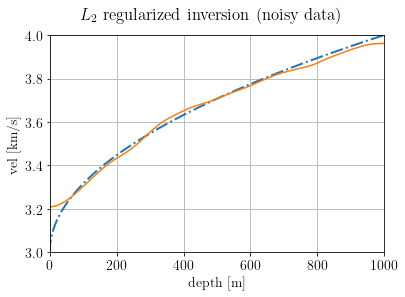

In [20]:
fig, ax = plt.subplots()
ax.plot(z, 1.e-3*vel,label='true model',linewidth=2,linestyle='-.')
ax.plot(z, 1.e-3/VSP_prob_regD1.model.plot(),label='inverted model')
ax.set_xlabel("depth [m]"), ax.set_ylabel("vel [km/s]")
ax.set_ylim(3,4), ax.set_xlim(0,1000)
fig.suptitle("$L_2$ regularized inversion (noisy data)")
plt.show()

In the second case (i.e., when a prior model is employed), the objective function to be minimized is written as follows:
\begin{align}
\phi_{smooth}(\mathbf{m})=\frac{1}{2}\|G \mathbf{m} - \mathbf{d}_{obs} \|_2^2 + \frac{\epsilon^2}{2} \|\mathbf{m} - \mathbf{m}_{prior}\|_2^2,
\end{align}
where $\mathbf{m}_{prior}$ is the prior model vector expressed as the following velocity profile:
\begin{align}
v_{prior}(z)  = 3100.+ 1.0 z
\end{align}

In [21]:
model_prior = o.VectorNumpy(1.0/(3100.0 + z))

In [22]:
# Instantiating regularized problem with prior model and noisy data
VSP_prob_prior = o.LeastSquaresRegularized(model_true.clone().zero(), noisy_data,VSP_10,epsilon=1.0,prior_model=model_prior)

# Estimating a value for the regularization weight epsilon
epsilon_balance = VSP_prob_prior.estimate_epsilon(True)
VSP_prob_prior.epsilon = epsilon_balance * 2.5e-1

Epsilon Scale evaluation
	Epsilon balancing the data-space gradients is: 2.04e+02


In [23]:
LCGsolver.run(VSP_prob_prior,verbose=True)

##########################################################################################
            CG Solver
    Restart folder: /tmp/restart_2022-04-22T01-51-41.263912/
##########################################################################################

iter = 0000, obj = 7.31713e-01, rnorm = 1.21e+00, gnorm = 2.52e+02, feval = 00002
iter = 0001, obj = 9.94834e-03, rnorm = 1.41e-01, gnorm = 1.06e+01, feval = 00004
iter = 0002, obj = 9.88438e-04, rnorm = 4.45e-02, gnorm = 2.66e+00, feval = 00006
iter = 0003, obj = 1.01552e-04, rnorm = 1.43e-02, gnorm = 4.98e-01, feval = 00008
iter = 0004, obj = 6.56218e-05, rnorm = 1.15e-02, gnorm = 5.48e-02, feval = 00010
iter = 0005, obj = 6.51493e-05, rnorm = 1.14e-02, gnorm = 4.49e-03, feval = 00012
iter = 0006, obj = 6.51460e-05, rnorm = 1.14e-02, gnorm = 2.74e-04, feval = 00014
iter = 0007, obj = 6.51460e-05, rnorm = 1.14e-02, gnorm = 1.22e-05, feval = 00016
iter = 0008, obj = 6.51460e-05, rnorm = 1.14e-02, gnorm = 4.34e-07, feval = 00

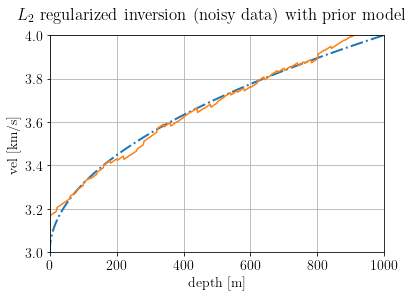

In [24]:
fig, ax = plt.subplots()
ax.plot(z, 1.e-3*vel,label='true model',linewidth=2,linestyle='-.')
ax.plot(z, 1.e-3/VSP_prob_prior.model.plot(),label='inverted model')
ax.set_xlabel("depth [m]"), ax.set_ylabel("vel [km/s]")
ax.set_ylim(3,4), ax.set_xlim(0,1000)
fig.suptitle("$L_2$ regularized inversion (noisy data) with prior model")
plt.show()